In [1]:
from datascience import *
%matplotlib inline
path_data = '../../../../data/'
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

# Múltiplas Categorias

Se os painéis do júri são representativos da população elegível continua sendo uma questão importante. Vamos abordar isso no contexto de painéis mais recentes do que o de Robert Swain na década de 1960.

O processo geral de avaliação será o mesmo de antes. Mas desta vez, consideraremos os jurados em múltiplas categorias raciais e étnicas, não apenas duas. Do ponto de vista técnico, isso significará que precisamos criar uma nova estatística para simular. Depois de simular e chegar a uma conclusão, examinaremos algumas das causas subjacentes das discrepâncias que observamos.

## Seleção do Júri no Condado de Alameda

Em 2010, a American Civil Liberties Union (ACLU) do norte da Califórnia apresentou um [relatório](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf "Relatório ACLU_NC") sobre a seleção do júri no Condado de Alameda, Califórnia. O relatório concluiu que certos grupos raciais e étnicos estão sub-representados entre os jurados no Condado de Alameda e sugeriu algumas reformas no processo pelo qual os jurados elegíveis são designados para os painéis. Nesta seção, analisaremos os dados fornecidos pela ACLU.

Como você viu na seção anterior, os jurados são selecionados de um painel de jurados maior. Por lei, o painel de jurados deve ser representativo da população de jurados elegíveis. Na Califórnia, a palavra "representativo" é claramente definida como "selecionado aleatoriamente". A Seção 197 do Código de Processo Civil da Califórnia diz: "Todas as pessoas selecionadas para o serviço de júri devem ser selecionadas aleatoriamente, de uma fonte ou fontes inclusivas de uma amostra representativa da população da área atendida pelo tribunal."

Aqui, "selecionado para o serviço de júri" significa ser selecionado para estar no painel de jurados.

## Composição dos Painéis no Condado de Alameda

O foco do estudo da ACLU do norte da Califórnia foi a composição racial e étnica dos painéis de jurados no Condado de Alameda. A ACLU compilou dados sobre a composição dos painéis de júri em 11 julgamentos por crimes no Condado de Alameda nos anos de 2009 e 2010. Nesses painéis, o número total de pessoas que se apresentaram para o serviço de júri foi de 1453. A ACLU reuniu dados demográficos de todos esses jurados potenciais e comparou esses dados com a composição de todos os jurados elegíveis no condado.

Os dados estão tabulados abaixo em uma tabela chamada `jury`. Em cada categoria, o primeiro valor numérico é a proporção de todos os candidatos a jurados elegíveis nessa categoria. O segundo valor é a proporção de pessoas nessa categoria entre aquelas que se apresentaram para o processo de seleção no júri.

Os rótulos para as diferentes categorias são retirados do relatório da ACLU, que diz: "A categoria "outros" inclui pessoas que se identificaram como mestiças sem identificar uma identidade racial principal e indivíduos que não identificaram uma raça ou etnia." O rótulo `Asian/PI` significa "Asiático ou Ilhéu do Pacífico". O rótulo `Black/AA` significa "Negro ou Afro-Americano".

In [2]:
jury = Table().with_columns(
    'Ethnicity', make_array('Asian/PI', 'Black/AA', 'Caucasian', 'Hispanic', 'Other'),
    'Eligible', make_array(0.15, 0.18, 0.54, 0.12, 0.01),
    'Panels', make_array(0.26, 0.08, 0.54, 0.08, 0.04)
)

jury

Ethnicity,Eligible,Panels
Asian/PI,0.15,0.26
Black/AA,0.18,0.08
Caucasian,0.54,0.54
Hispanic,0.12,0.08
Other,0.01,0.04


Algumas etnias estão super-representadas e algumas estão sub-representadas nos painéis do júri do estudo. Em particular, os painelistas nas categorias Negro/AA e Hispânico estão sub-representados. 

Um gráfico de barras é útil para visualizar as diferenças.

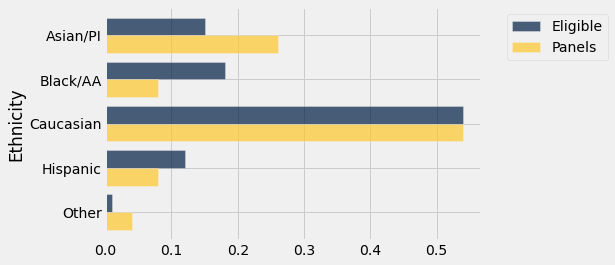

In [3]:
jury.barh('Ethnicity')

## Comparação com Painéis Selecionados Aleatoriamente
E se selecionarmos uma amostra aleatória de 1.453 pessoas da população de jurados elegíveis? A distribuição de suas etnias se parecerá com a distribuição dos painéis acima?

Podemos responder a essas perguntas usando `sample_proportions` e aumentando a tabela `jury` com uma coluna das proporções em nossa amostra.

**Nota técnica.** Amostras aleatórias de jurados potenciais seriam selecionadas sem reposição. No entanto, quando o tamanho de uma amostra é pequeno em relação ao tamanho da população, a amostragem sem reposição se assemelha à amostragem com reposição; as proporções na população não mudam muito entre as seleções. A população de jurados elegíveis no Condado de Alameda é de mais de um milhão, e comparado a isso, um tamanho de amostra de cerca de 1500 é bastante pequeno. Portanto, amostraremos com reposição.

Na célula abaixo, selecionamos aleatoriamente 1453 vezes da distribuição de jurados elegíveis e mostramos a distribuição da amostra aleatória junto com as distribuições dos jurados elegíveis e do painel nos dados.

In [4]:
eligible_population = jury.column('Eligible')
sample_distribution = sample_proportions(1453, eligible_population)
panels_and_sample = jury.with_column('Random Sample', sample_distribution)
panels_and_sample

Ethnicity,Eligible,Panels,Random Sample
Asian/PI,0.15,0.26,0.14384
Black/AA,0.18,0.08,0.163799
Caucasian,0.54,0.54,0.538197
Hispanic,0.12,0.08,0.143152
Other,0.01,0.04,0.0110117


A distribuição da amostra aleatória é bastante próxima da distribuição da população elegível, ao contrário da distribuição dos painéis. Como sempre, ajuda a visualizar.

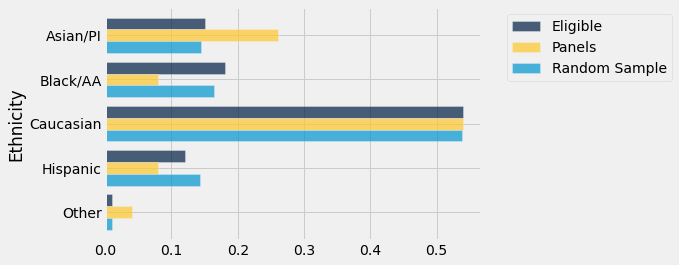

In [5]:
panels_and_sample.barh('Ethnicity')

O gráfico de barras mostra que a distribuição da amostra aleatória se assemelha à população elegível, mas a distribuição dos painéis não.

Para avaliar se esta observação é específica de uma amostra aleatória ou mais geral, podemos simular vários painéis sob o modelo de seleção aleatória e ver o que as simulações prevêem. Mas não seremos capazes de olhar para milhares de gráficos de barras como o precisamos de uma estatística que nos ajude a avaliar se o modelo ou a seleção aleatória é ou não suportado pelos dados.

## Uma Nova Estatística: A Distância Entre Duas Distribuições
Sabemos como medir o quão diferentes são dois números: se os números são $x$ e $y$, a distância entre eles é $\vert x-y \vert$. Agora temos que quantificar a distância entre duas distribuições. Por exemplo, temos que medir a distância entre as distribuições azul e dourada abaixo.

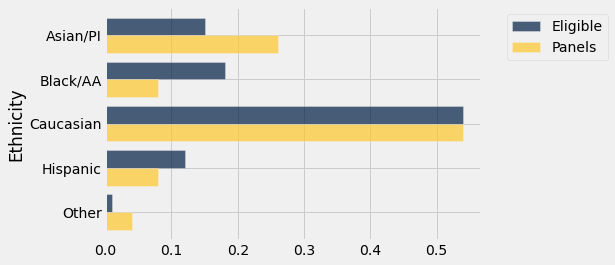

In [6]:
jury.barh('Ethnicity')

Para isso calcularemos uma quantidade chamada *distância de variação total* entre duas distribuições. O cálculo é uma extensão de como encontramos a distância entre dois números.

Para calcular a distância total de variação, primeiro encontramos a diferença entre as duas proporções em cada categoria.

In [7]:
# Augment the table with a column of differences between proportions

jury_with_diffs = jury.with_column(
    'Difference', jury.column('Panels') - jury.column('Eligible')
)
jury_with_diffs

Ethnicity,Eligible,Panels,Difference
Asian/PI,0.15,0.26,0.11
Black/AA,0.18,0.08,-0.1
Caucasian,0.54,0.54,0
Hispanic,0.12,0.08,-0.04
Other,0.01,0.04,0.03


Observe a coluna `Difference` e note que a soma de suas entradas é 0: as entradas positivas somam 0.14, cancelando exatamente o total das entradas negativas, que é -0.14.

Esta é uma evidência numérica do fato de que, no gráfico de barras, as barras douradas excedem as barras azuis exatamente na mesma medida em que as barras azuis excedem as douradas. As proporções em cada uma das duas colunas `Panels` e `Eligible` somam 1, e assim o balanço entre suas entradas deve somar 0.

Para evitar o cancelamento, removemos os sinais negativos e então somamos todas as entradas. Mas isso nos dá duas vezes o total das entradas positivas (equivalente a duas vezes o total das entradas negativas, com o sinal removido). Não precisamos dessa duplicação, então dividimos a soma por 2.

In [8]:
jury_with_diffs = jury_with_diffs.with_column(
    'Absolute Difference', np.abs(jury_with_diffs.column('Difference'))
)

jury_with_diffs

Ethnicity,Eligible,Panels,Difference,Absolute Difference
Asian/PI,0.15,0.26,0.11,0.11
Black/AA,0.18,0.08,-0.1,0.1
Caucasian,0.54,0.54,0,0
Hispanic,0.12,0.08,-0.04,0.04
Other,0.01,0.04,0.03,0.03


In [9]:
jury_with_diffs.column('Absolute Difference').sum() / 2

0.14

Essa quantidade 0.14 é a *distância de variação total* (DVT) entre a distribuição de etnias na população de jurados elegíveis e a distribuição nos painéis.

Em geral, a distância de variação total entre duas distribuições mede o quão próximas as distribuições estão. Quanto maior a DVT, mais diferentes as duas distribuições parecem.

**Nota Técnica:** Poderíamos ter obtido o mesmo resultado apenas somando as diferenças positivas. Mas nosso método de incluir todas as diferenças absolutas elimina a necessidade de acompanhar quais diferenças são positivas e quais não são.

Usaremos a distância de variação total entre distribuições como a estatística a ser simulada sob a hipótese de seleção aleatória. Valores grandes da distância serão evidência contra a seleção aleatória.

## Simulando a Estatística Sob o Modelo
Para ver como a DVT varia em amostras aleatórias, vamos simulá-la repetidamente sob o modelo de seleção aleatória da população elegível.

Vamos organizar nosso cálculo. Como vamos calcular a distância de variação total repetidamente, primeiro escreveremos uma função que a calcule para duas distribuições dadas.

A função `total_variation_distance` recebe duas matrizes contendo as distribuições a serem comparadas e retorna a DVT entre elas.

In [10]:
def total_variation_distance(distribution_1, distribution_2):
    return sum(np.abs(distribution_1 - distribution_2)) / 2

Esta função nos ajudará a calcular nossa estatística em cada repetição da simulação. Mas primeiro vamos verificar se ela dá a resposta correta quando a usamos para calcular a distância entre as distribuições azul (elegível) e dourada (painéis) acima. Estas são a distribuição no estudo da ACLU.

In [11]:
total_variation_distance(jury.column('Panels'), jury.column('Eligible'))

0.14

Isso concorda com o valor que calculamos diretamente sem usar a função.

Na célula abaixo, usamos a função para calcular a DVT entre as distribuições dos jurados elegíveis e uma amostra aleatória. Lembre-se de que `eligible_population` é a matriz que contém a distribuição dos jurados elegíveis, e que o tamanho da nossa amostra é 1453.

Na primeira linha, usamos `sample_proportions` para gerar uma amostra aleatória da população elegível. Na linha seguinte, usamos `total_variation_distance` para calcular a DVT entre as distribuições na amostra aleatória e a população elegível.

In [20]:
sample_distribution = sample_proportions(1453, eligible_population)
total_variation_distance(sample_distribution, eligible_population)

0.018265657260839632

Execute a célula algumas vezes e observe que as distâncias são consideravelmente menores que 0,14, a distância entre a distribuição dos painéis e os jurados elegíveis.

Agora estamos prontos para executar uma simulação para avaliar o modelo de seleção aleatória.

### Simulando um Valor da Estatística
Da mesma forma que começamos toda simulação, vamos definir uma função `one_simulated_tvd` que retorna um valor simulado da distância de variação total sob a hipótese de seleção aleatória.

O código no corpo da definição é baseado na célula acima.

In [13]:
# Simulate one simulated value of 
# the total variation distance between
# the distribution of a sample selected at random
# and the distribution of the eligible population

def one_simulated_tvd():
    sample_distribution = sample_proportions(1453, eligible_population)
    return total_variation_distance(sample_distribution, eligible_population)   

### Simulando Múltiplos valores da Estatística
Agora podemos aplicar o processo familiar de usar um loop `for` para criar uma matriz consistindo de 5000 dessas distâncias.

In [14]:
tvds = make_array()
repetitions = 5000
for i in np.arange(repetitions):
    tvds = np.append(tvds, one_simulated_tvd())

## Avaliando o Modelo de Seleção Aleatória

Aqui está o histograma empírico das distâncias simuladas. Ele mostra que se você escolher 1453 jurados aleatoriamente do conjunto de candidatos elegíveis, então a distância entre as distribuições dos jurados e a população elegível raramente será superior a cerca de 0,05.

No entanto, os painéis no estudo não eram tão semelhantes à população elegível. A distância de variação total entre os painéis e a população foi de 0,14, mostrada como o ponto vermelho no eixo horizontal. Está muito além da cauda do histograma e não se parece com uma distância típica entre as distribuições de uma amostra aleatória e a população elegível.

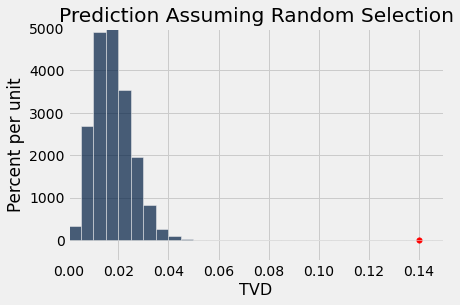

In [15]:
Table().with_column('TVD', tvds).hist(bins=np.arange(0, 0.2, 0.005))

# Parâmetros de plotagem; você pode ignorar este código
plots.title('Prediction Assuming Random Selection')
plots.xlim(0, 0.15)
plots.ylim(-5, 50)
plots.scatter(0.14, 0, color='red', s=30);

A simulação mostra que a composição dos painéis no estudo da ACLU não é consistente com o modelo de seleção aleatória. Nossa análise apoia a conclusão da ACLU de que os painéis não eram representativos da distribuição prevista para os jurados elegíveis.

## Razões para o Preconceito
Como na maioria das análises desse tipo, a nossa não diz *por que* as distribuições são diferentes. No entanto, esses motivos são importantes para serem compreendidos. Se os painéis do júri não representarem a população de jurados elegíveis, isso pode ter um grande efeito no devido processo legal e na justiça dos julgamentos por júri.

O relatório da ACLU discute várias possíveis razões para as discrepâncias e sugere alguns remédios. Alguns são puramente práticos, mas têm um grande impacto. Por exemplo, enquanto podemos considerar de alta qualidade a amostragem aleatória em Python, a seleção dos painéis usou outro software. A análise da ACLU revelou que o software não funcionava bem, contribuindo para a seleção tendenciosa. Utilizar um software melhor é um remédio claro.

Mais significativamente, os painéis do júri do Condado de Alameda não são selecionados a partir de toda a população elegível. O [site](http://www.alameda.courts.ca.gov/pages.aspx/faqs) do Tribunal Superior do Condado de Alameda diz: "O objetivo do tribunal é fornecer uma seção transversal precisa da população do condado. Os nomes dos jurados são selecionados aleatoriamente entre todos os que são eleitores registrados e/ou têm carteira de motorista ou cartão de identificação emitido pelo Departamento de Veículos Motorizados." 

Esse processo exclui jurados elegíveis que não estão nessas listas. Ter uma identificação emitida pelo estado ou estar registrado para votar provavelmente está associado à renda e, portanto, também à raça e etnia, devido ao preconceito histórico contra comunidades negras e hispânicas. Isso leva à sub-representação desses grupos nos painéis.

Aqueles na lista têm que ser alcançados para serem informados sobre sua convocação para o júri. No entanto, pessoas em comunidades com poucos recursos nem sempre têm endereços fixos. Registros de endereços desatualizados, falta de verificação cruzada com outras listas, como as de serviços públicos, etc., todos podem contribuir para uma seleção tendenciosa.

Uma vez alcançados, os potenciais jurados ainda têm que ser capazes de comparecer. O primeiro dia de serviço no júri não é remunerado, e a remuneração para os dias subsequentes é de \$15 por dia. Embora os empregadores sejam obrigados por lei a dispensar funcionários que têm serviço no júri, eles não são obrigados a fornecer remuneração, e alguns empregadores não o fazem. Em uma região tão cara como a Área da Baía, isso pode se tornar um motivo para os jurados não responderem às convocações do júri. Embora os jurados possam ser dispensados por dificuldades econômicas severas, até mesmo o processo de solicitar a dispensa pode estar fora do alcance de alguns jurados. Do outro lado da baía, líderes municipais em São Francisco estão tentando reduzir essa forma de preconceito pilotando um [programa](https://sftreasurer.org/new-ca-bill-pilots-higher-compensation-low-income-jurors-san-francisco) que fornece uma compensação de \$100 por dia para jurados de baixa renda.

## Qualidade dos Dados
Desenvolvemos uma técnica que nos ajuda a decidir se uma distribuição se parece com uma amostra aleatória de outra. Mas devemos examinar nossas fontes de dados para entender melhor exatamente o que podemos concluir de nossa análise. Uma boa ciência de dados inclui um exame cuidadoso de como os dados foram coletados.

**Jurados Elegíveis.** É importante ter em mente que nem todos são elegíveis para servir em um júri. Em seu [site](http://www.alameda.courts.ca.gov/pages.aspx/jury-duty-overview), o Tribunal Superior do Condado de Alameda diz: "Você pode ser chamado para servir se tiver 18 anos, for cidadão dos EUA e residente do condado ou distrito onde foi convocado. Você deve ser capaz de entender inglês e estar fisicamente e mentalmente apto para servir. Além disso, não deve ter servido como jurado de qualquer tipo nos últimos 12 meses, nem ter sido condenado por um crime grave."

Embora o Censo seja uma fonte natural de informações demográficas, o Censo não coleta dados em todas essas categorias. Portanto, a ACLU teve que obter a demografia dos jurados elegíveis de alguma outra forma. 

O que eles usaram foram estimativas desenvolvidas por um professor da Universidade Estadual de San Diego para um julgamento no Condado de Alameda em 2002. Essas estimativas eram baseadas no Censo de 2000 e também levavam em conta os critérios necessários para a elegibilidade como jurado.

Portanto, devemos ter em mente que a distribuição que usamos para a população de jurados elegíveis é em si uma estimativa e, portanto, está sujeita a erro. Além disso, como observou a ACLU, usar estimativas baseadas no Censo de 2000 para populações em 2010 pode não ser preciso devido às mudanças demográficas na Califórnia.

Assim, a distribuição usada para a população de jurados elegíveis pode não ser precisa.

**Painéis.** Não está claro no relatório exatamente como os 1453 painelistas foram classificados nas diferentes categorias étnicas. O relatório diz apenas que "advogados ... cooperaram na coleta de dados do pool de jurados".

Fatores sociais, culturais e políticos significativos afetam quem é classificado ou auto-classificado em cada categoria étnica. Também não está claro se as definições dessas categorias nos painéis eram as mesmas usadas nas estimativas da distribuição de jurados elegíveis. Isso levanta questões sobre a correspondência entre as duas distribuições que estão sendo comparadas.

Além disso, os dados sobre os painelistas foram obtidos daqueles que se apresentaram para o serviço. Como discutimos, nem todos os painelistas o fazem. As razões para não se apresentar estão associadas à raça e etnia, e afetam de forma desproporcional os painelistas de comunidades com poucos recursos. 

Responder às convocações do júri é exigido por lei. Mas, como observou a ACLU, na época do estudo, o Condado de Alameda não tinha um processo eficaz para acompanhar os jurados em potencial que foram convocados, mas não compareceram. A ACLU recomendou a criação de "um programa de falta de comparecimento que exige, no mínimo, o envio de uma segunda notificação aos jurados em potencial." 

De fato, fazer o acompanhamento de não comparecimentos reduziria o viés. Para nossa análise, devemos reconhecer que não temos os dados necessários para preencher as informações demográficas dos painelistas que foram selecionados, mas não se apresentaram para o serviço.

## Conclusão

Devido à discussão acima, é importante ser preciso sobre o que podemos concluir de nossa análise.

- Podemos concluir que a distribuição fornecida para os painelistas que se apresentaram para o serviço não se parece com uma amostra aleatória da distribuição estimada na população de jurados elegíveis.

Nossa discussão, assim como a discussão no relatório da ACLU, expõe as razões para algumas das diferenças observadas entre as duas distribuições e por que os membros do painel convocados não podem reportar. Quase todas as razões têm suas raízes no preconceito racial histórico na sociedade, e são exemplos das consequências negativas duradouras desse preconceito.